This notebook relies on the functionality from #06, it just packages the functionality slightly differently and makes it easier to train on different data and compare results.

In [1]:
from utils import *

In [2]:
dir_name = '22k_2sec_better_centered_mel_db'

In [3]:
def get_datasource(dir_name='22k_2sec_better_centered_mel_db'):
    trn_df = pd.read_csv('data/train.csv')

    trn_paths = list(Path(f'data/img_train_{dir_name}/').iterdir())
    tst_paths = list(Path(f'data/img_test_{dir_name}/').iterdir())

    splits = pd.read_pickle('data/splits.pkl')

    trn_df.fname = trn_df.fname.apply(lambda x: x.split('.')[0] + '.png')
    trn_df.set_index('fname', inplace=True)
    lbl_dict = trn_df.to_dict()['label']

    tfms = [[PILImage.create], [path2fn, lbl_dict.__getitem__, Categorize()]]
    dsrc = DataSource(trn_paths, tfms, splits=splits[0])
    
    return dsrc

In [4]:
dsrc = get_datasource(dir_name)

In [5]:
NUM_WORKERS=12
BS=64

item_img_tfms = [ToTensor()]
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=BS, num_workers=NUM_WORKERS)

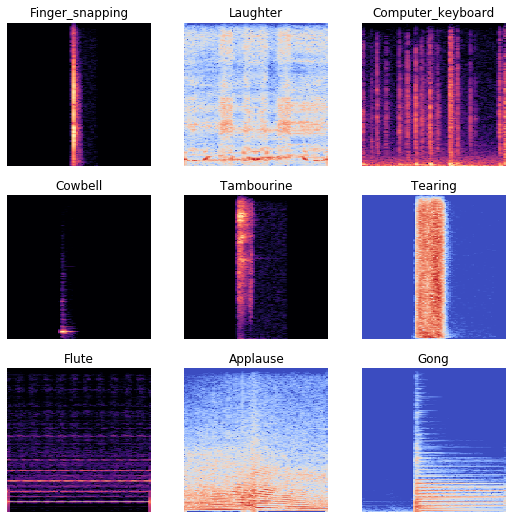

In [6]:
dbch.show_batch(max_n=9)

In [7]:
from torchvision.models import resnext50_32x4d

In [8]:
def get_learner(opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8), config=cnn_config(ps=0.33)):
    return cnn_learner(
        dbch,
        resnext50_32x4d,
        opt_func=opt_func,
        metrics=[accuracy, top_3_accuracy],
        config=config,
    )

In [30]:
learn = get_learner()

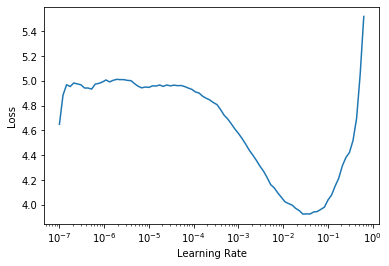

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.732285,1.956306,0.478419,0.695788,00:44
1,1.928561,1.736961,0.539262,0.752470,00:44
2,1.546720,1.714697,0.562142,0.760790,00:44
3,1.276408,1.606594,0.574623,0.777951,00:44
4,1.033171,1.625109,0.600104,0.787831,00:44
5,0.870650,1.591209,0.615705,0.791472,00:44
6,0.629206,1.679365,0.602704,0.797192,00:44
7,0.507854,1.640322,0.636505,0.808632,00:44
8,0.383289,1.700607,0.648986,0.816953,00:44
9,0.282644,1.748574,0.643266,0.812793,00:44


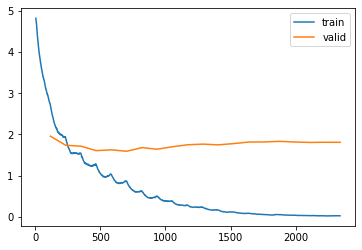

In [33]:
learn.recorder.plot_loss()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.023106,1.823349,0.669787,0.832033,01:01
1,0.025589,1.817006,0.673947,0.830473,01:01
2,0.021719,1.804256,0.669787,0.834633,01:01
3,0.023634,1.833812,0.669267,0.835153,01:01
4,0.021727,1.871875,0.663027,0.832033,01:01
5,0.026312,1.847079,0.671347,0.831513,01:01
6,0.035376,1.913962,0.667187,0.828393,01:01
7,0.044598,1.960634,0.663027,0.831513,01:01
8,0.049218,1.928847,0.669787,0.830473,01:02
9,0.053750,1.956008,0.682267,0.834113,01:01


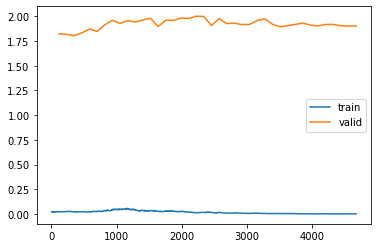

In [35]:
learn.recorder.plot_loss()

In [37]:
learn.save(name())

ykokhwtvit


In [45]:
def create_submission_and_submit(sub_name, dir_name):
    tst_paths = list(Path(f'data/img_test_{dir_name}/').iterdir())
    preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]
    predicted_label_idxs = preds.argsort(descending=True)[:, :3]
    
    fns, predicted_labels = [], []

    for path, idxs in zip(tst_paths, predicted_label_idxs):
        fns.append(f'{path.stem}.wav')
        predicted_labels.append([dbch.vocab[idx] for idx in idxs])
        
    sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
    sub.label = sub.label.apply(lambda lst: ' '.join(lst))
    sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)
    
    !kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

In [46]:
create_submission_and_submit(name(), dir_name)

dqlupnjhuj


100%|██████████████████████████████████████| 94.4k/94.4k [00:03<00:00, 28.2kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge

This model achieves 0.78727 on the private LB and 0.80398 on the public one. I would like to share with you an observation and test it in the next model I will train, as I think it might be quite relevant to working with spectograms.

CNNs excel at detecting shapes and texture but they are poor at identifying the relative and absolute position of detected features. This is by design and is referred to as [translation invariance](https://stats.stackexchange.com/a/208949/64261). This is one way a neural network learns to generalize from data - a dog that appears in the lower hand corner of an image is a dog and should the same dog be positioned in the upper hand corner, it wouldn't be any less of a dog.

With spectograms the position matters. The vertical displacement is how we assign meaning to pixel values - at y = 20 we have frequency of 100 Hz and at y = 30 the pixel intensity tells us something about the component of sound that is of frequency 400 Hz (I made up the numbers).

Assuming this information is important, translation invariance is not something that we want for our model. With a standard CNN architecture we cannot completely remove it, but we can at least alleviate the problem. One of doing so is removing the pooling layer - a global average pooling layer will remove any positional information going into the classifier altogether.

Let's see how a model without a global average pooling layer will perform.

In [50]:
def get_learner(opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8), custom_head=None):
    return cnn_learner(
        dbch,
        resnext50_32x4d,
        opt_func=opt_func,
        metrics=[accuracy, top_3_accuracy],
        config=cnn_config(ps=0.33),
        custom_head=custom_head
    )

In [74]:
sum(l.numel() for l in list(learn.model)[1].parameters())

2127360

Our head has 2 127 360 paramters. Let's see if we can create a new one that would have a similar number of params.

In [140]:
head = nn.Sequential(
    ConvLayer(2048, 256, 1),
    ConvLayer(256, 256, 1),
    Flatten(),
    LinBnDrop(12544, 120, p=0.33, act=nn.ReLU(inplace=True)),
    LinBnDrop(120, 41, p=0.16)
)

In [141]:
sum(l.numel() for l in list(head.parameters()))

2126376

In [142]:
head

Sequential(
  (0): ConvLayer(
    (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): full: False
  (3): LinBnDrop(
    (0): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.33, inplace=False)
    (2): Linear(in_features=12544, out_features=120, bias=False)
    (3): ReLU(inplace=True)
  )
  (4): LinBnDrop(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.16, inplace=False)
    (2): Linear(in_features=120, out_features=41, bias=False)
  )
)

Let's try this out.

In [143]:
learn = get_learner(config={'custom_head': head})

In [144]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.91 GiB total capacity; 9.54 GiB already allocated; 34.25 MiB free; 57.23 MiB cached)